# 1. Project Overview

This project focuses on large-scale text data analysis using Natural Language Processing (NLP) techniques.
The main objective is to clean, preprocess, and convert textual news articles into numerical vectors so that they can be used for downstream machine learning tasks such as clustering, classification, or similarity analysis.

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install -U gensim

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 27.9/27.9 MB 56.8 MB/s eta 0:00:00


In [3]:
!pip install pandas requests tqdm

PROJECT STURCTURED
URL
↓
requests.get()
 ↓
ZIP download
 ↓
BytesIO → Memory file
 ↓
zipfile open
 ↓
CSV read
 ↓
DataFrame
 ↓
Append to list


# 📦 Libraries Used – Short Description

- This project uses multiple Python libraries for data downloading, preprocessing, text cleaning, feature extraction, and vectorization in Natural Language Processing (NLP).

- requests – Downloads datasets and files from online sources using HTTP requests.

- zipfile & BytesIO – Handle ZIP files directly in memory without saving them to disk.

- tqdm – Displays progress bars to track long-running loops.

- re – Performs text cleaning using regular expressions.

- nltk (Stopwords & Lemmatizer) – Removes common words and converts words to their base form for better text normalization.

- SentenceTransformer – Generates dense, context-aware sentence embeddings.

- warnings – Suppresses unnecessary warning messages.

- pandas – Manages and processes structured data using DataFrames.

- numpy – Supports numerical operations and array computations.

- CountVectorizer – Converts text into Bag-of-Words numerical features.

- HashingVectorizer – Creates memory-efficient fixed-size text vectors using hashing.

- TfidfTransformer – Transforms word counts into TF-IDF weighted features.

- gensim & Word2Vec – Learns semantic word embeddings from large text corpora.

In [4]:
import requests
import zipfile
from io import BytesIO
from tqdm import tqdm
import re
import nltk
from sklearn.cluster import MiniBatchKMeans
from scipy import sparse
import glob
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer
import gensim
from gensim.models import Word2Vec
from sklearn.feature_extraction.text import HashingVectorizer
from sklearn.feature_extraction.text import TfidfTransformer

# 2. Data Collection

This project collects global news metadata from the GDELT Project Global Knowledge Graph (GKG) dataset.
Daily GKG ZIP files for a one-month period are automatically downloaded using HTTP requests.
Only successfully retrieved files (status code 200) are processed to ensure data reliability.
Each compressed file is extracted in memory and read as a tab-separated CSV file.
All daily datasets are merged into a single consolidated DataFrame for large-scale analysis.
The final dataset provides rich information on global events, entities, and sentiment for NLP and clustering tasks.

In [5]:
base_url = "http://data.gdeltproject.org/gkg/"

# Last 1 month dates
dates = pd.date_range("2025-12-25", "2026-01-25")

dfs = []

for d in tqdm(dates):
    fname = d.strftime("%Y%m%d") + ".gkg.csv.zip"  #strftime string format me convert karta hai:
    url = base_url + fname

    r = requests.get(url)
    if r.status_code == 200:   #We check status_code == 200 to confirm that the request was successful before using the downloaded data.
        z = zipfile.ZipFile(BytesIO(r.content))
        df = pd.read_csv(
            z.open(z.namelist()[0]),
            sep='\t',
              #header=None,
            low_memory=False
        )
        dfs.append(df)

final_df = pd.concat(dfs, ignore_index=True)

print("Total records:", final_df.shape)

100%|██████████| 32/32 [01:23<00:00,  2.60s/it]


Total records: (2213824, 11)


In [6]:
final_df.head()

,DATE,NUMARTS,COUNTS,THEMES,LOCATIONS,PERSONS,ORGANIZATIONS,TONE,CAMEOEVENTIDS,SOURCES,SOURCEURLS
0,20251225,1,NaN,TAX_FNCACT;TAX_FNCACT_GUARD;SECURITY_SERVICES;...,"3#New Orleans, Louisiana, United States#US#USL...",jeff landry,national guard;supreme court,"0.337837837837838,4.05405405405405,3.716216216...","1280894597,1280894920,1280894921",katc.com,https://www.katc.com/politics/the-president/na...
1,20251225,1,NaN,NaN,"3#Syracuse University, New York, United States...",ryan mcmahon;donnie freeman;patricia yager;lou...,syracuse university,"-0.700934579439252,2.92056074766355,3.62149532...",NaN,syracuse.com,https://www.syracuse.com/news/2025/12/the-late...
2,20251225,1,NaN,TAX_FNCACT;TAX_FNCACT_BUSINESSMAN;LEADER;TAX_F...,"1#Israel#IS#IS#31.5#34.75#IS;4#Tegucigalpa, Fr...",nasry asfura;joe biden;rixi moncada;nasry juan...,national electoral council;libre party;united ...,"-3.89908256880734,3.44036697247706,7.339449541...","1280886322,1280886733,1280886734,1280886735,12...",deccanchronicle.com,https://www.deccanchronicle.com/world/trump-ba...
3,20251225,1,NaN,WB_696_PUBLIC_SECTOR_MANAGEMENT;WB_840_JUSTICE...,"3#Chicago, Illinois, United States#US#USIL#41....",ryan goodman;samuel alito;april perry;josh ger...,supreme court;district court;high court;suprem...,"-2.58620689655172,3.16091954022989,5.747126436...","1280974186,1280974374,1280974375,1280974383,12...",newsweek.com,https://www.newsweek.com/brett-kavanaugh-made-...
4,20251225,1,NaN,ECON_STOCKMARKET;EPU_ECONOMY_HISTORIC;WB_698_T...,1#China#CH#CH#35#105#CH,elliott hill,NaN,"1.31086142322097,3.93258426966292,2.6217228464...",1280896485,fool.com,https://www.fool.com/investing/2025/12/24/nike...


# Data Collection

- The dataset is downloaded from an online ZIP source using the requests library.

- The ZIP file is handled in memory using BytesIO and extracted using zipfile.

- Multiple CSV files are read and merged into a single Pandas DataFrame.

- Due to the very large dataset size, a random sample of 2,000,000 records is selected for analysis to ensure computational feasibility.

In [7]:
df = final_df.sample(2_000_000, random_state=42)
print(df.shape)

(2000000, 11)


In [8]:
df.head()

,DATE,NUMARTS,COUNTS,THEMES,LOCATIONS,PERSONS,ORGANIZATIONS,TONE,CAMEOEVENTIDS,SOURCES,SOURCEURLS
2040170,20260123,1,NaN,TAX_FNCACT;TAX_FNCACT_ACTOR;TAX_ETHNICITY;TAX_...,1#United States#US#US#39.828175#-98.5795#US,sean penn;paul thomas anderson;leonardo dicapr...,actor academy,"4.54545454545455,5.63636363636364,1.0909090909...",NaN,film-news.co.uk,https://www.film-news.co.uk/news/UK/124353/The...
1985212,20260122,1,NaN,LEADER;TAX_FNCACT;TAX_FNCACT_PRESIDENT;USPEC_P...,1#Switzerland#SZ#SZ#47#8#SZ;1#United States#US...,marco rubio;mark rutte;steve witkoff,united states;world economic forum in davos,"1.11111111111111,4.16666666666667,3.0555555555...","1285242919,1285242920",dailypost.ng,https://dailypost.ng/2026/01/22/trump-announce...
550968,20260104,1,KILL#115##1#Venezuela#VE#VE#8#-66#VE;,CRISISLEX_CRISISLEXREC;LEADER;TAX_FNCACT;TAX_F...,1#United States#US#US#39.828175#-98.5795#US;1#...,jimmy gurule;marco rubio;michael schmitt;manue...,notre dame law school;new york times;united st...,"-4.34227330779055,1.27713920817369,5.619412515...","1282071748,1282071749,1282069553,1282069597,12...",fox10phoenix.com,https://www.fox10phoenix.com/news/can-u-s-run-...
1128676,20260112,1,"SEIZE#4#vehicles#4#Canberra, Australian Capita...",TAX_ETHNICITY;TAX_ETHNICITY_AUSTRALIAN;MANMADE...,"4#Sydney, New South Wales, Australia#AS#AS02#-...",holden commodore;azhar bhamji;migelly shaw;zoo...,united states,"0.840978593272171,3.36391437308868,2.522935779...",NaN,dailymail.co.uk,https://www.dailymail.co.uk/news/article-15454...
212962,20251229,1,"KILL#400##4#Jonglei, Wilayat Junqoley, South S...",TAX_ETHNICITY;TAX_ETHNICITY_SUDANESE;USPEC_POL...,"4#Jonglei, Wilayat Junqoley, South Sudan#OD#OD...",salva kiir mayardit,NaN,"-5.16666666666667,3.83333333333333,9,12.833333...",NaN,radiotamazuj.org,https://www.radiotamazuj.org/en/news/article/o...


**# 3. Dataset Description**

The dataset contains news-related information with the following key columns:

- date

- article_title

- article_content

- locations

- persons

- sentiment

- source

- url

**## Data Size**

- The dataset is large-scale, containing millions of records.

- Text-heavy columns such as article_title and article_content are the primary focus.

In [9]:
df.columns = [
    "date",
    "num_articles",
    "confidence",
    "article_title",
    "locations",
    "persons",
    "article_content",
    "sentiment",
    "event_ids",
    "source",
    "url"
]


In [10]:
df.head()


,date,num_articles,confidence,article_title,locations,persons,article_content,sentiment,event_ids,source,url
2040170,20260123,1,NaN,TAX_FNCACT;TAX_FNCACT_ACTOR;TAX_ETHNICITY;TAX_...,1#United States#US#US#39.828175#-98.5795#US,sean penn;paul thomas anderson;leonardo dicapr...,actor academy,"4.54545454545455,5.63636363636364,1.0909090909...",NaN,film-news.co.uk,https://www.film-news.co.uk/news/UK/124353/The...
1985212,20260122,1,NaN,LEADER;TAX_FNCACT;TAX_FNCACT_PRESIDENT;USPEC_P...,1#Switzerland#SZ#SZ#47#8#SZ;1#United States#US...,marco rubio;mark rutte;steve witkoff,united states;world economic forum in davos,"1.11111111111111,4.16666666666667,3.0555555555...","1285242919,1285242920",dailypost.ng,https://dailypost.ng/2026/01/22/trump-announce...
550968,20260104,1,KILL#115##1#Venezuela#VE#VE#8#-66#VE;,CRISISLEX_CRISISLEXREC;LEADER;TAX_FNCACT;TAX_F...,1#United States#US#US#39.828175#-98.5795#US;1#...,jimmy gurule;marco rubio;michael schmitt;manue...,notre dame law school;new york times;united st...,"-4.34227330779055,1.27713920817369,5.619412515...","1282071748,1282071749,1282069553,1282069597,12...",fox10phoenix.com,https://www.fox10phoenix.com/news/can-u-s-run-...
1128676,20260112,1,"SEIZE#4#vehicles#4#Canberra, Australian Capita...",TAX_ETHNICITY;TAX_ETHNICITY_AUSTRALIAN;MANMADE...,"4#Sydney, New South Wales, Australia#AS#AS02#-...",holden commodore;azhar bhamji;migelly shaw;zoo...,united states,"0.840978593272171,3.36391437308868,2.522935779...",NaN,dailymail.co.uk,https://www.dailymail.co.uk/news/article-15454...
212962,20251229,1,"KILL#400##4#Jonglei, Wilayat Junqoley, South S...",TAX_ETHNICITY;TAX_ETHNICITY_SUDANESE;USPEC_POL...,"4#Jonglei, Wilayat Junqoley, South Sudan#OD#OD...",salva kiir mayardit,NaN,"-5.16666666666667,3.83333333333333,9,12.833333...",NaN,radiotamazuj.org,https://www.radiotamazuj.org/en/news/article/o...


In [11]:
df["date"].head()


,date
2040170,20260123
1985212,20260122
550968,20260104
1128676,20260112
212962,20251229


In [12]:
df["date"] = pd.to_datetime(
    df["date"].astype(str),
    format="%Y%m%d",
    errors="coerce"
)

In [13]:
df["date"].head()

,date
2040170,2026-01-23
1985212,2026-01-22
550968,2026-01-04
1128676,2026-01-12
212962,2025-12-29


In [14]:
df.duplicated().sum()

np.int64(0)

In [15]:
df.shape

(2000000, 11)

In [16]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2000000 entries, 2040170 to 332111
Data columns (total 11 columns):
 #   Column           Dtype         
---  ------           -----         
 0   date             datetime64[ns]
 1   num_articles     int64         
 2   confidence       object        
 3   article_title    object        
 4   locations        object        
 5   persons          object        
 6   article_content  object        
 7   sentiment        object        
 8   event_ids        object        
 9   source           object        
 10  url              object        
dtypes: datetime64[ns](1), int64(1), object(9)
memory usage: 183.1+ MB


In [17]:
df.tail()

,date,num_articles,confidence,article_title,locations,persons,article_content,sentiment,event_ids,source,url
1971731,2026-01-22,1,NaN,LEADER;TAX_FNCACT;TAX_FNCACT_PRESIDENT;USPEC_P...,1#United States#US#US#39.828175#-98.5795#US;1#...,donald trump;imelda marcos,NaN,"2.32558139534884,6.31229235880399,3.9867109634...","1285339873,1285384326,1285384409,1285385091",thebeaverton.com,https://www.thebeaverton.com/2026/01/trump-thr...
359426,2025-12-31,1,NaN,NaN,"1#United Arab Emirates#AE#AE#24#54#AE;4#Dubai,...",binance alpha,NaN,"7.03971119133574,7.5812274368231,0.54151624548...",NaN,financial-news.co.uk,https://www.financial-news.co.uk/meet48-and-me...
1153205,2026-01-12,1,NaN,TAX_FNCACT;TAX_FNCACT_CHIEF;TAX_FNCACT_MINISTE...,"5#Odisha, Orissa, India#IN#IN21#20.5#84.4167#-...",prithviraj harichandan;lok seva bhawan;bibhuti...,works department,"3.43347639484979,6.43776824034335,3.0042918454...",NaN,pragativadi.com,https://pragativadi.com/odisha-cm-mohan-charan...
52946,2025-12-26,1,NaN,UNGP_FORESTS_RIVERS_OCEANS;TAX_FNCACT;TAX_FNCA...,"3#Skaneateles Lake, New York, United States#US...",karen meriwether;harriet hollister spencer,finger lakes land,"4.2042042042042,5.10510510510511,0.90090090090...",NaN,yahoo.com,https://www.yahoo.com/news/articles/finger-lak...
332111,2025-12-31,1,NaN,NaN,"3#Sacramento, California, United States#US#USC...",jalen duren;lebron jame;cade cunningham;isaiah...,NaN,"-1.53321976149915,3.57751277683135,5.110732538...",NaN,sandiegosun.com,http://www.sandiegosun.com/news/278783694/nba-...


In [18]:
df.isnull().sum()

,0
date,0
num_articles,0
confidence,1690333
article_title,236096
locations,0
persons,317974
article_content,362280
sentiment,0
event_ids,1022335
source,0


In [19]:
df.describe()

,date,num_articles
count,2000000,2.000000e+06
mean,2026-01-10 14:37:46.545599744,1.102051e+00
min,2025-12-25 00:00:00,1.000000e+00
25%,2026-01-04 00:00:00,1.000000e+00
50%,2026-01-11 00:00:00,1.000000e+00
75%,2026-01-18 00:00:00,1.000000e+00
max,2026-01-25 00:00:00,6.620000e+02
std,NaN,1.739780e+00


In [20]:
df.columns

Index(['date', 'num_articles', 'confidence', 'article_title', 'locations',
       'persons', 'article_content', 'sentiment', 'event_ids', 'source',
       'url'],
      dtype='object')

# **Missing Value (Null Percentage) Analysis**

- The purpose of this analysis is to identify and quantify missing values in the dataset. Understanding the percentage of null values in each column helps in making informed decisions about data cleaning, feature selection, and preprocessing strategies.

In [ ]:
null_percent=(df.isnull().sum() / len(df))*100
null_percent.round(2)

,0
date,0.00
num_articles,0.00
confidence,84.52
article_title,11.80
locations,0.00
persons,15.90
article_content,18.11
sentiment,0.00
event_ids,51.12
source,0.00


## **Missing Value Analysis **
After analyzing the dataset, the percentage of missing values in each column was calculated. The results showed that some columns contained a very high proportion of missing data, which could negatively impact model performance and data quality.

** 📊 Missing Value Summary (Key Columns) **
- confidence → 84.52% missing values
- event_ids → 51.12% missing values

These two columns have more than half of their data missing, making them unreliable for meaningful analysis.

In [ ]:
df.drop(['confidence','event_ids'],axis=1,inplace=True)

In [21]:
df.head()

,date,num_articles,confidence,article_title,locations,persons,article_content,sentiment,event_ids,source,url
2040170,2026-01-23,1,NaN,TAX_FNCACT;TAX_FNCACT_ACTOR;TAX_ETHNICITY;TAX_...,1#United States#US#US#39.828175#-98.5795#US,sean penn;paul thomas anderson;leonardo dicapr...,actor academy,"4.54545454545455,5.63636363636364,1.0909090909...",NaN,film-news.co.uk,https://www.film-news.co.uk/news/UK/124353/The...
1985212,2026-01-22,1,NaN,LEADER;TAX_FNCACT;TAX_FNCACT_PRESIDENT;USPEC_P...,1#Switzerland#SZ#SZ#47#8#SZ;1#United States#US...,marco rubio;mark rutte;steve witkoff,united states;world economic forum in davos,"1.11111111111111,4.16666666666667,3.0555555555...","1285242919,1285242920",dailypost.ng,https://dailypost.ng/2026/01/22/trump-announce...
550968,2026-01-04,1,KILL#115##1#Venezuela#VE#VE#8#-66#VE;,CRISISLEX_CRISISLEXREC;LEADER;TAX_FNCACT;TAX_F...,1#United States#US#US#39.828175#-98.5795#US;1#...,jimmy gurule;marco rubio;michael schmitt;manue...,notre dame law school;new york times;united st...,"-4.34227330779055,1.27713920817369,5.619412515...","1282071748,1282071749,1282069553,1282069597,12...",fox10phoenix.com,https://www.fox10phoenix.com/news/can-u-s-run-...
1128676,2026-01-12,1,"SEIZE#4#vehicles#4#Canberra, Australian Capita...",TAX_ETHNICITY;TAX_ETHNICITY_AUSTRALIAN;MANMADE...,"4#Sydney, New South Wales, Australia#AS#AS02#-...",holden commodore;azhar bhamji;migelly shaw;zoo...,united states,"0.840978593272171,3.36391437308868,2.522935779...",NaN,dailymail.co.uk,https://www.dailymail.co.uk/news/article-15454...
212962,2025-12-29,1,"KILL#400##4#Jonglei, Wilayat Junqoley, South S...",TAX_ETHNICITY;TAX_ETHNICITY_SUDANESE;USPEC_POL...,"4#Jonglei, Wilayat Junqoley, South Sudan#OD#OD...",salva kiir mayardit,NaN,"-5.16666666666667,3.83333333333333,9,12.833333...",NaN,radiotamazuj.org,https://www.radiotamazuj.org/en/news/article/o...


#** Data Cleaning & Preprocessing**
##4.1 Handling Missing Values

- Missing values in text columns are replaced with empty strings.

- Less useful or highly sparse columns such as confidence and event_ids are dropped.

- Missing values in the persons column are filled with "Unknown".

## 4.2 Text Combination

A new column text is created by combining article titles and article content.

This improves contextual understanding and provides richer textual input.

In [22]:
# Step 1: Fill only text columns (ok)
df["article_title"] = df["article_title"].fillna("")
df["article_content"] = df["article_content"].fillna("")
df["persons"] = df["persons"].fillna("Unknown")
df["locations"] = df["locations"].fillna("")

# ❗ Step 2 (MODIFIED): Use ONLY article_content for modeling text
# (GDELT title is mostly themes, so don't mix it here)
#df["text"] = df["article_content"]

# Step 3: Drop empty rows (ok)
#df = df[df["text"].str.strip() != ""]

# Check
#print(df.shape)
#df[["article_title","article_content","text"]].head()


In [23]:
# ---- Step 1: Construct project fields (OK) ----
df["project_title"] = (
    df["source"].fillna("") + " | " +
    df["article_content"].fillna("").str[:120]
)

df["project_content"] = df["article_content"].fillna("")


In [24]:
df["model_text"] = (
    df["project_content"] + " " +
    df["locations"] + " " +
    df["persons"]
)


In [25]:
df.isnull().sum()

,0
date,0
num_articles,0
confidence,1690333
article_title,0
locations,0
persons,0
article_content,0
sentiment,0
event_ids,1022335
source,0


** 5. Text Cleaning**

- A custom text-cleaning pipeline is applied:
- Converted all text to lowercase

##Removed:
- URLs
- Special characters
- Numbers
- Removed extra whitespaces

- Eliminated English stopwords using NLTK
- Applied lemmatization using WordNet Lemmatizer

📌 The cleaned text is stored in a new column: clean_text

In [26]:
df["clean_text"] = (
    df["model_text"]
    .str.lower()
    .str.replace(r"http\S+|www\S+", "", regex=True)
    .str.replace(r"[^a-z\s]", " ", regex=True)
    .str.replace(r"\s+", " ", regex=True)
    .str.strip()
)


In [27]:
df_subset = df[[
    "project_title",
    "project_content",
    "clean_text",
    "source",
    "url",
    "date",
    "sentiment",
    "persons",
    "locations"
]]


In [28]:
df_subset.head()


,project_title,project_content,clean_text,source,url,date,sentiment,persons,locations
2040170,film-news.co.uk | actor academy,actor academy,actor academy united states us us us sean penn...,film-news.co.uk,https://www.film-news.co.uk/news/UK/124353/The...,2026-01-23,"4.54545454545455,5.63636363636364,1.0909090909...",sean penn;paul thomas anderson;leonardo dicapr...,1#United States#US#US#39.828175#-98.5795#US
1985212,dailypost.ng | united states;world economic fo...,united states;world economic forum in davos,united states world economic forum in davos sw...,dailypost.ng,https://dailypost.ng/2026/01/22/trump-announce...,2026-01-22,"1.11111111111111,4.16666666666667,3.0555555555...",marco rubio;mark rutte;steve witkoff,1#Switzerland#SZ#SZ#47#8#SZ;1#United States#US...
550968,fox10phoenix.com | notre dame law school;new y...,notre dame law school;new york times;united st...,notre dame law school new york times united st...,fox10phoenix.com,https://www.fox10phoenix.com/news/can-u-s-run-...,2026-01-04,"-4.34227330779055,1.27713920817369,5.619412515...",jimmy gurule;marco rubio;michael schmitt;manue...,1#United States#US#US#39.828175#-98.5795#US;1#...
1128676,dailymail.co.uk | united states,united states,united states sydney new south wales australia...,dailymail.co.uk,https://www.dailymail.co.uk/news/article-15454...,2026-01-12,"0.840978593272171,3.36391437308868,2.522935779...",holden commodore;azhar bhamji;migelly shaw;zoo...,"4#Sydney, New South Wales, Australia#AS#AS02#-..."
212962,radiotamazuj.org |,,jonglei wilayat junqoley south sudan od od sou...,radiotamazuj.org,https://www.radiotamazuj.org/en/news/article/o...,2025-12-29,"-5.16666666666667,3.83333333333333,9,12.833333...",salva kiir mayardit,"4#Jonglei, Wilayat Junqoley, South Sudan#OD#OD..."


In [29]:
df_subset[["project_title","project_content","clean_text"]].head()

,project_title,project_content,clean_text
2040170,film-news.co.uk | actor academy,actor academy,actor academy united states us us us sean penn...
1985212,dailypost.ng | united states;world economic fo...,united states;world economic forum in davos,united states world economic forum in davos sw...
550968,fox10phoenix.com | notre dame law school;new y...,notre dame law school;new york times;united st...,notre dame law school new york times united st...
1128676,dailymail.co.uk | united states,united states,united states sydney new south wales australia...
212962,radiotamazuj.org |,,jonglei wilayat junqoley south sudan od od sou...


In [30]:
df_subset["clean_text"]

,clean_text
2040170,actor academy united states us us us sean penn...
1985212,united states world economic forum in davos sw...
550968,notre dame law school new york times united st...
1128676,united states sydney new south wales australia...
212962,jonglei wilayat junqoley south sudan od od sou...
...,...
1971731,united states us us us greenland gl gl gl wash...
359426,united arab emirates ae ae ae dubai dubayy uni...
1153205,works department odisha orissa india in in ber...
52946,finger lakes land skaneateles lake new york un...


In [31]:
nltk.download('stopwords')

stop_words = set(stopwords.words('english'))

df_subset["clean_text"] = df_subset["clean_text"].apply(
    lambda x: " ".join([word for word in x.split() if word not in stop_words])
)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [32]:
nltk.download('wordnet')
from nltk.stem import WordNetLemmatizer

lemmatizer = WordNetLemmatizer()

df_subset["clean_text"] = df_subset["clean_text"].apply(
    lambda x: " ".join([lemmatizer.lemmatize(word) for word in x.split()])
)


[nltk_data] Downloading package wordnet to /root/nltk_data...


In [35]:
df_subset["clean_text"]

,clean_text
2040170,actor academy united state u u u sean penn pau...
1985212,united state world economic forum davos switze...
550968,notre dame law school new york time united sta...
1128676,united state sydney new south wale australia k...
212962,jonglei wilayat junqoley south sudan od od sou...
...,...
1971731,united state u u u greenland gl gl gl washingt...
359426,united arab emirate ae ae ae dubai dubayy unit...
1153205,work department odisha orissa india berhampur ...
52946,finger lake land skaneateles lake new york uni...


# **Text Vectorization Techniques**

# **6.1 Bag of Words (BoW)**
Implemented using CountVectorizer

## Configuration:
- Maximum features: 20,000
- N-grams: unigrams and bigrams
- Rare words removed using min_df=5
- Extremely common words removed using max_df=0.9

In [36]:
#vectorizer = CountVectorizer(
    max_features=20000,  # vocabalry size
    ngram_range=(1,2),   # n_gram
    min_df=5,            # remove the rare word
    max_df=0.9,          #common words remove
)

X_bow = vectorizer.fit_transform(final_df["clean_text"])


KeyError: 'clean_text'

# **Problem Of Bag of words **
- Despite applying feature limits and frequency thresholds, the BoW representation caused system instability due to:

## 1. Very High Dimensionality
- Even after limiting features, the vocabulary size remained extremely large
- Bigram combinations further increased feature space

## 2. Memory Exhaustion
- BoW generates a huge sparse matrix
- Processing millions of text records exceeded available RAM
- This resulted in system crashes and kernel restarts

## 3. Poor Scalability
- BoW does not scale efficiently for large-scale text corpora
- Not suitable for resource-constrained environments

# **6.2 Word2Vec Embeddings**
- Trained a Word2Vec Skip-gram model
### Parameters:
- Vector size: 100
- Window size: 5
- Minimum word count: 5
- Skip-gram model for better semantic representation

#### Each document is converted into a fixed-length vector by:
- Averaging the word vectors of all words in the document

In [ ]:
sentences = [text.split() for text in df["clean_text"]]
w2v_model = Word2Vec(
    sentences=sentences,
    vector_size=100,
    window=5,
    min_count=5,
    workers=4,
    sg=1   # skip-gram (better semantics)
)


In [ ]:
len(w2v_model.wv)

33581

In [ ]:
import numpy as np
w2v_model = Word2Vec()

def sent_vector(sentence, model, dim=100):
    words = sentence.split()
    vectors = [model.wv[w] for w in words if w in model.wv]
    if len(vectors) == 0:
        return np.zeros(dim)
    return np.mean(vectors, axis=0)

X_w2v = np.vstack(df["clean_text"].apply(lambda x: sent_vector(x, w2v_model)))


In [ ]:
import numpy as np

def sent_vector(sentence, model, dim=100):
    words = sentence.split()
    vectors = [model.wv[w] for w in words if w in model.wv]
    if len(vectors) == 0:
        return np.zeros(dim)
    return np.mean(vectors, axis=0)

X_w2v = np.vstack(df["clean_text"].apply(lambda x: sent_vector(x, w2v_model)))


# **Hashing Vectorizer**

In [37]:
from sklearn.feature_extraction.text import HashingVectorizer

hash_vectorizer = HashingVectorizer(
    n_features=2**18,      # 262,144 features (safe for 2M rows)
    stop_words="english",
    alternate_sign=False,
    norm="l2"
)

X_hash = hash_vectorizer.transform(df_subset["clean_text"])
print(X_hash.shape)


(2000000, 262144)


In [38]:
X_hash[0].toarray()

array([[0., 0., 0., ..., 0., 0., 0.]])

In [39]:
X_hash[0].nonzero()

(array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=int32),
 array([ 19867,  44097,  64878,  70278,  72042,  78532,  98358, 136939,
        166815, 208321, 213422, 235223, 240459], dtype=int32))

**EVENT CLUSTERING — KMeans (Mini-Batch Variant)**

# Why KMeans (Mini-Batch Variant)

- We selected KMeans (Mini-Batch Variant) for Event Clustering because:

- Handles large dataset (≈ 2M articles) efficiently by processing data in small batches

- Memory-safe and fast, unlike standard KMeans

- Works well with sparse text data (Hashing TF-IDF)

- Suitable for grouping similar news articles into real-world events

- More practical than HDBSCAN or Agglomerative for large-scale data

##Noise handling:
Small clusters (few articles) were treated as irrelevant/noise.

# **ELBOW Techniques**
###Why Elbow Technique was used

Elbow technique was used to determine an appropriate number of clusters in a data-driven manner using a representative sample. It provided a computationally feasible, interpretable, and objective way to balance cluster quality and model complexity for large-scale text data.

Take representative sample

In [40]:
sample_df = df_subset.sample(n=200000, random_state=42)

In [41]:
from sklearn.feature_extraction.text import HashingVectorizer

hash_vectorizer = HashingVectorizer(
    n_features=2**18,
    stop_words="english",
    alternate_sign=False,
    norm="l2"
)

X_sample = hash_vectorizer.transform(sample_df["clean_text"])

**Compute inertia for different k**

In [42]:
K = [10,20,30,40,50,60,70]
inertia = []

for k in K:
    model = MiniBatchKMeans(n_clusters=k, batch_size=10000, random_state=42)
    model.fit(X_sample)
    inertia.append(model.inertia_)

**Plot elbow graph**

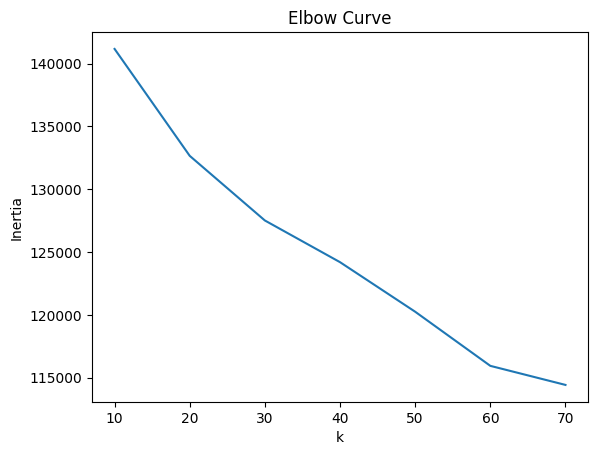

In [43]:
import matplotlib.pyplot as plt

plt.plot(K, inertia)
plt.xlabel("k")
plt.ylabel("Inertia")
plt.title("Elbow Curve")
plt.show()


#Elbow Graph Explanation

he elbow curve did not show a sharp inflection point, which is common in large-scale text datasets. However, around 35–50 clusters the reduction in inertia became much slower. Therefore, I selected 40 clusters as a balanced choice between interpretability and granularity.”

##Observation from your Elbow Graph

###From your elbow curve:

- Inertia drops sharply from k = 10 to around k = 30

- After k ≈ 35–50, the curve becomes much flatter

- There is no clear single “perfect elbow”, which is common in large text datasets

👉 This means: we did not get one obvious best k, so we had to pick a reasonable balance.

**EVENT CLUSTERING — KMeans (Mini-Batch Variant)**
##Why 40?
he optimal number of clusters was selected using the Elbow Method. The inertia decreased rapidly up to around 30 clusters and then began to flatten, indicating diminishing returns beyond this point. Since no sharp elbow was visible, we selected 40 clusters as a balanced choice between interpretability and granularity. This number allows meaningful separation of real-world events while avoiding excessive fragmentation into very small, less useful clusters.”

In [44]:
from sklearn.cluster import MiniBatchKMeans

kmeans = MiniBatchKMeans(
    n_clusters=40,
    batch_size=10000,
    random_state=42
)

df["event_cluster"] = kmeans.fit_predict(X_hash)


In [45]:
df["event_cluster"].value_counts()

,count
event_cluster,
5,218928
37,212148
1,192003
3,99952
16,86377
31,83336
30,71237
14,66976
4,63448


In [46]:
df["event_cluster"].value_counts().sort_index()


,count
event_cluster,
0,40090
1,192003
2,8581
3,99952
4,63448
5,218928
6,29234
7,12818
8,42140


**Handle noisy or unrelated articles**


- After clustering, we analyzed the empirical distribution of cluster sizes. The smallest cluster contained 6,279 articles, while the mean cluster size was approximately 50,000. To filter weak or less reliable clusters, we treated clusters with fewer than 10,000 articles as noise. This threshold was chosen based on the natural gap between small and medium-sized clusters, ensuring that major real-world events were preserved while minimizing the impact of fragmented or less coherent groups.”

In [47]:
cluster_sizes = df["event_cluster"].value_counts()
print(cluster_sizes.describe())
print("\nTop 15 clusters:")
print(cluster_sizes.head(15))
print("\nSmallest 15 clusters:")
print(cluster_sizes.tail(15))

count        40.000000
mean      50000.000000
std       51408.914513
min        6279.000000
25%       14322.000000
50%       37038.500000
75%       62287.500000
max      218928.000000
Name: count, dtype: float64

Top 15 clusters:
event_cluster
5     218928
37    212148
1     192003
3      99952
16     86377
31     83336
30     71237
14     66976
4      63448
34     62367
17     62261
19     51281
26     50397
18     47611
28     47051
Name: count, dtype: int64

Smallest 15 clusters:
event_cluster
33    29510
6     29234
15    28450
38    16975
25    14583
36    13539
23    13397
7     12818
27    10548
2      8581
11     8451
20     8377
9      8112
24     7206
12     6279
Name: count, dtype: int64


Treat clusters smaller than ~10,000 as “weak/noisy”.

Why 10,000?

Your smallest = 6,279

Next few are ~7–9k

After that most are > 12k

So 10k is a natural cutoff.

In [48]:
cluster_sizes = df["event_cluster"].value_counts()

# Define noise threshold
noise_clusters = cluster_sizes[cluster_sizes < 10000].index

df["is_noise"] = df["event_cluster"].isin(noise_clusters)

print(df["is_noise"].value_counts())


is_noise
False    1952994
True       47006
Name: count, dtype: int64


In [49]:
df_clean = df[df["is_noise"] == False]
print("Final shape:", df_clean.shape)

Final shape: (1952994, 17)


EVENT LABELING
------------------
- Assign a meaningful label to each cluster:
  Example:
  - “Russia–Ukraine Conflict”
  - “OpenAI Product Launch”
  - “Stock Market Crash”

- Labels can be generated using:
  - Frequent keywords
  - Cluster summaries
  - Rule-based logic


EVENT LABELING

Although the text was already preprocessed for clustering, additional lightweight filtering (stopword removal and minimum word length) was applied during keyword extraction to ensure that only meaningful terms were used for event labeling.

Keyword extraction was performed using a streaming Counter-based approach rather than concatenating all documents, which prevents memory overflow when processing millions of articles.


[ ]


In [50]:
from collections import Counter
from tqdm import tqdm

cluster_keywords = {}

custom_stop = set([
    "tax","fncact","crisislex","general","worldlanguages",
    "united","states","news","article"
])

for c in tqdm(df["event_cluster"].unique()):
    texts = df.loc[df["event_cluster"] == c, "clean_text"].dropna()

    big_text = " ".join(texts.tolist())
    words = big_text.split()

    words = [w for w in words if len(w) > 3 and w not in custom_stop]

    cluster_keywords[c] = [w for w,_ in Counter(words).most_common(8)]


100%|██████████| 40/40 [00:33<00:00,  1.18it/s]


In [51]:
df["year_month"] = df["date"].dt.to_period("M").astype(str)

In [52]:
print("cluster keyword 0:",cluster_keywords[0])
print("cluster keyword: 1",cluster_keywords[1])


cluster keyword 0: ['israel', 'spain', 'germany', 'gaza', 'madrid', 'bank', 'west', 'unknown']
cluster keyword: 1 ['department', 'county', 'university', 'center', 'school', 'health', 'national', 'carolina']


In [53]:
def make_project_label(cluster_id):
    words = cluster_keywords.get(cluster_id, [])
    topic = " ".join(words[:2]).title()   # top 2 keywords as theme
    month = df[df["event_cluster"] == cluster_id]["year_month"].mode()[0]

    if topic.strip() == "":
        topic = "General News"

    return f"{topic} ({month})"

label_map = {
    c: make_project_label(c)
    for c in df["event_cluster"].unique()
}

df["event_label"] = df["event_cluster"].map(label_map)


In [54]:
def make_better_label(cluster_id):

    words = cluster_keywords.get(cluster_id, [])
    text_blob = " ".join(words).lower()

    month = df[df["event_cluster"] == cluster_id]["year_month"].mode()[0]

    if "israel" in text_blob and "palestine" in text_blob:
        base = "Israel–Palestine Tensions"

    elif "davos" in text_blob or "forum" in text_blob:
        base = "World Economic Forum in Davos"

    elif "venezuela" in text_blob and "washington" in text_blob:
        base = "US–Venezuela Relations"

    elif "australia" in text_blob:
        base = "Australia Domestic News"

    elif any(w in text_blob for w in ["film","actor","academy","hollywood"]):
        base = "Film & Entertainment News"

    elif any(w in text_blob for w in ["sudan","south sudan","juba"]):
        base = "South Sudan Politics"

    elif any(w in text_blob for w in ["lake","river","forest","climate","environment"]):
        base = "Environmental News"

    elif any(w in text_blob for w in ["nba","football","cricket","sports"]):
        base = "Sports News"

    elif any(w in text_blob for w in ["india","odisha","delhi","mumbai"]):
        base = "India Current Affairs"

    else:
        base = "General News Event"

    return f"{base} ({month})"


In [55]:
label_map = {c: make_better_label(c) for c in df["event_cluster"].unique()}
df["event_label"] = df["event_cluster"].map(label_map)


In [56]:
df[["event_cluster","event_label"]].drop_duplicates().head(10)


,event_cluster,event_label
2040170,1,General News Event (2026-01)
1985212,32,World Economic Forum in Davos (2026-01)
550968,22,US–Venezuela Relations (2026-01)
1128676,4,Australia Domestic News (2026-01)
212962,37,India Current Affairs (2026-01)
319265,9,Australia Domestic News (2026-01)
63678,15,General News Event (2026-01)
644622,7,Australia Domestic News (2026-01)
2159992,34,Australia Domestic News (2026-01)
438016,5,General News Event (2026-01)


In [57]:
print(cluster_keywords)

{np.int32(1): ['department', 'county', 'university', 'center', 'school', 'health', 'national', 'carolina'], np.int32(32): ['switzerland', 'davos', 'world', 'forum', 'economic', 'france', 'israel', 'washington'], np.int32(22): ['venezuela', 'washington', 'federal', 'distrito', 'caracas', 'trump', 'donald', 'usdc'], np.int32(4): ['australia', 'south', 'wales', 'victoria', 'australian', 'sydney', 'queensland', 'melbourne'], np.int32(37): ['south', 'unknown', 'national', 'philippines', 'africa', 'international', 'council', 'india'], np.int32(9): ['indonesia', 'jakarta', 'jawa', 'raya', 'barat', 'malaysia', 'australia', 'national'], np.int32(15): ['nigeria', 'state', 'lagos', 'abuja', 'capital', 'federal', 'territory', 'national'], np.int32(7): ['zealand', 'australia', 'auckland', 'wellington', 'unknown', 'south', 'india', 'police'], np.int32(34): ['kingdom', 'unknown', 'national', 'john', 'australia', 'university', 'keir', 'starmer'], np.int32(5): ['florida', 'usfl', 'washington', 'texas',

# EVENT TIMELINE CONSTRUCTION
-------------------------------
For EACH event cluster:
- Sort articles by published date
- Create a timeline showing:
  - Event start
  - Key developments
  - Latest updates

Timeline should clearly show how the event evolved over time.


In [58]:
event_overview = (
    df
    .groupby("event_cluster")
    .agg({
        "event_label": "first",
        "date": ["min", "max"],
        "url": "count"
    })
)

event_overview


event_label       date             \
                                                 first        min        max   
event_cluster                                                                  
0                         General News Event (2026-01) 2025-12-25 2026-01-25   
1                         General News Event (2026-01) 2025-12-25 2026-01-25   
2                      India Current Affairs (2026-01) 2025-12-25 2026-01-25   
3                         General News Event (2026-01) 2025-12-25 2026-01-25   
4                    Australia Domestic News (2026-01) 2025-12-25 2026-01-25   
5                         General News Event (2026-01) 2025-12-25 2026-01-25   
6                    Australia Domestic News (2026-01) 2025-12-25 2026-01-25   
7                    Australia Domestic News (2026-01) 2025-12-25 2026-01-25   
8                         General News Event (2026-01) 2025-12-25 2026-01-25   
9                    Australia Domestic News (2026-01) 2025-12-25 2026-01-25   
10                        General News Event (2026-01) 2025-12-25 2026-01-25   
11                     India Current Affairs (2026-01) 2025-12-25 2026-01-25   
12                        General News Event (2026-01) 2025-12-25 2026-01-25   
13                        General News Event (2026-01) 2025-12-25 2026-01-25   
14                     India Current Affairs (2026-01) 2025-12-25 2026-01-25   
15                        General News Event (2026-01) 2025-12-25 2026-01-25   
16                     India Current Affairs (2026-01) 2025-12-25 2026-01-25   
17                        General News Event (2026-01) 2025-12-25 2026-01-25   
18                        General News Event (2026-01) 2025-12-25 2026-01-25   
19                 Film & Entertainment News (2026-01) 2025-12-25 2026-01-25   
20                        General News Event (2026-01) 2025-12-25 2026-01-25   
21                        General News Event (2026-01) 2025-12-25 2026-01-25   
22                    US–Venezuela Relations (2026-01) 2025-12-25 2026-01-25   
23                     India Current Affairs (2026-01) 2025-12-25 2026-01-25   
24                        General News Event (2026-01) 2025-12-25 2026-01-25   
25                   Australia Domestic News (2026-01) 2025-12-25 2026-01-25   
26                        General News Event (2026-01) 2025-12-25 2026-01-25   
27                        General News Event (2026-01) 2025-12-25 2026-01-25   
28                        General News Event (2026-01) 2025-12-25 2026-01-25   
29                   Australia Domestic News (2026-01) 2025-12-25 2026-01-25   
30                        General News Event (2026-01) 2025-12-25 2026-01-25   
31                        General News Event (2026-01) 2025-12-25 2026-01-25   
32             World Economic Forum in Davos (2026-01) 2025-12-25 2026-01-25   
33                     India Current Affairs (2026-01) 2025-12-25 2026-01-25   
34                   Australia Domestic News (2026-01) 2025-12-25 2026-01-25   
35                        General News Event (2026-01) 2025-12-25 2026-01-25   
36                        General News Event (2026-01) 2025-12-25 2026-01-25   
37                     India Current Affairs (2026-01) 2025-12-25 2026-01-25   
38                     India Current Affairs (2026-01) 2025-12-25 2026-01-25   
39                        General News Event (2026-01) 2025-12-25 2026-01-25   

                  url  
                count  
event_cluster          
0               40090  
1              192003  
2                8581  
3               99952  
4               63448  
5              218928  
6               29234  
7               12818  
8               42140  
9                8112  
10              32945  
11               8451  
12               6279  
13              41197  
14              66976  
15              28450  
16              86377  
17              62261  
18              47611  
19              51281  
20               8377  
21              30878  
22

In [59]:
timeline_0 = (
    df[df["event_cluster"] == 0]
    .sort_values("date")
    [["date", "project_title", "url", "event_label"]]
)

timeline_0.head(10)


,date,project_title,url,event_label
8895,2025-12-25,aol.co.uk |,https://www.aol.co.uk/articles/former-nottingh...,General News Event (2026-01)
35007,2025-12-25,richmondandtwickenhamtimes.co.uk |,https://www.richmondandtwickenhamtimes.co.uk/n...,General News Event (2026-01)
41212,2025-12-25,countercurrents.org | india palestine solidari...,https://countercurrents.org/2025/12/a-christma...,General News Event (2026-01)
9801,2025-12-25,haaretz.com |,https://www.haaretz.com/israel-news/2025-12-25...,General News Event (2026-01)
40056,2025-12-25,clickondetroit.com |,https://www.clickondetroit.com/news/world/2025...,General News Event (2026-01)
5123,2025-12-25,meathchronicle.ie |,https://www.meathchronicle.ie/2025/12/25/forme...,General News Event (2026-01)
5013,2025-12-25,santamariatimes.com | hebrew university of jer...,https://santamariatimes.com/ap/international/m...,General News Event (2026-01)
14494,2025-12-25,dailypioneer.com | asian champions league,https://dailypioneer.com/news/al-ittihad-1-0-w...,General News Event (2026-01)
41057,2025-12-25,medscape.com | department of dermatology;schoo...,https://www.medscape.com/viewarticle/pan-europ...,General News Event (2026-01)
6872,2025-12-25,pjmedia.com | mary magdalene church;slavic net...,https://pjmedia.com/tim-o-brien/2025/12/25/whi...,General News Event (2026-01)


In [60]:
timeline_1 = df[df["event_cluster"]==1].sort_values("date")
timeline_2 = df[df["event_cluster"]==2].sort_values("date")

In [61]:
timeline_1

,date,num_articles,confidence,article_title,locations,persons,article_content,sentiment,event_ids,source,url,project_title,project_content,model_text,clean_text,event_cluster,is_noise,year_month,event_label
37641,2025-12-25,1,AFFECT#65##1#United States#US#US#39.828175#-98...,WB_286_TELECOMMUNICATIONS_AND_BROADBAND_ACCESS...,"2#California, United States#US#USCA#36.17#-119...",pilewskie lecuyer;britton mullens;pacific ocea...,bulletin of the american meteorological societ...,"-0.277143788718618,2.47799152266058,2.75513531...",NaN,skepticalscience.com,https://skepticalscience.com/new_research_2025...,skepticalscience.com | bulletin of the america...,bulletin of the american meteorological societ...,bulletin of the american meteorological societ...,bulletin of the american meteorological societ...,1,False,2025-12,General News Event (2026-01)
9091,2025-12-25,1,NaN,CRISISLEX_C07_SAFETY;CRISISLEX_T11_UPDATESSYMP...,"2#Georgia, United States#US#USGA#32.9866#-83.6...",angelique b mcclendon,georgia motorcycle safety program;georgia depa...,"2.1978021978022,4.3956043956044,2.197802197802...",1280898727,lagrangenews.com,https://www.lagrangenews.com/news/georgia-moto...,lagrangenews.com | georgia motorcycle safety p...,georgia motorcycle safety program;georgia depa...,georgia motorcycle safety program;georgia depa...,georgia motorcycle safety program georgia depa...,1,False,2025-12,General News Event (2026-01)
8758,2025-12-25,1,NaN,GENERAL_HEALTH;MEDICAL;TAX_FNCACT;TAX_FNCACT_D...,1#United States#US#US#39.828175#-98.5795#US,steve rogers;john walker,commission on superhuman activities;marvel stu...,"-1.40845070422535,3.59937402190923,5.007824726...","1280973341,1280890891,1280973518",comicbook.com,https://comicbook.com/movies/list/every-code-n...,comicbook.com | commission on superhuman activ...,commission on superhuman activities;marvel stu...,commission on superhuman activities;marvel stu...,commission on superhuman activities marvel stu...,1,False,2025-12,General News Event (2026-01)
32734,2025-12-25,1,NaN,TAX_ECON_PRICE;ECON_STOCKMARKET;TAX_FNCACT;TAX...,"2#Rhode Island, United States#US#USRI#41.6772#...",sanford c bernstein,cessna;textron;beechcraft;jpmorgan chase co;te...,"1.30890052356021,1.57068062827225,0.2617801047...","1280887838,1280888315",themarketsdaily.com,https://www.themarketsdaily.com/2025/12/25/tex...,themarketsdaily.com | cessna;textron;beechcraf...,cessna;textron;beechcraft;jpmorgan chase co;te...,cessna;textron;beechcraft;jpmorgan chase co;te...,cessna textron beechcraft jpmorgan chase co te...,1,False,2025-12,General News Event (2026-01)
16070,2025-12-25,1,NaN,ELECTION;DELAY;USPEC_UNCERTAINTY1;USPEC_POLITI...,1#Argentina#AR#AR#-34#-64#AR;1#Honduras#HO#HO#...,salvador nasralla;donald trump;marco rubio;nas...,national party;asfura national party;reuters;h...,"0,4.14507772020725,4.14507772020725,8.29015544...","1280884659,1280885268,1280885270,1280885271,12...",yasstribune.com.au,https://www.yasstribune.com.au/story/9141740/t...,yasstribune.com.au | national party;asfura nat...,national party;asfura national party;reuters;h...,national party;asfura national party;reuters;h...,national party asfura national party reuters h...,1,False,2025-12,General News Event (2026-01)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2197701,2026-01-25,1,NaN,NATURAL_DISASTER;NATURAL_DISASTER_BLIZZARD;WB_...,"3#Boston, Massachusetts, United States#US#USMA...",katie nickolaou,,"-2.24719101123596,1.68539325842697,3.932584269...",NaN,bostonglobe.com,https://www.bostonglobe.com/2026/01/25/metro/n...,bostonglobe.com |,,"3#Boston, Massachusetts, United States#US#USM...",boston massachusetts united states us usma kat...,1,False,2026-01,General News Event (2026-01)
2193068,2026-01-25,1,NaN,CRISISLEX_CRISISLEXREC;TAX_FNCACT;TAX_FNCACT_A...,1#United States#US#US#39.828175#-98.5795#US,miguel arias;angel lozano;nathan magsig;farah ...,department of homeland security,"-7.80346820809249,0.867052023121387,8.67052023...","

 # EVENT SUMMARY GENERATION
- Generate a short readable summary for each event:
  Example:
  “This event began in early March, gained global attention after X,
   and saw major developments on Y and Z.”

- You may use:
  - Extractive summarization
  - LLM-based summarization (optional)


In [64]:
def make_readable_summary(cluster_id):

    temp = df[df["event_cluster"] == cluster_id].sort_values("date")

    start = temp["date"].iloc[0]
    mid = temp["date"].iloc[len(temp)//2]
    end = temp["date"].iloc[-1]

    label = temp["event_label"].mode()[0]  # use your human label

    return (
        f"This event, related to '{label}', began on {start.date()}, "
        f"gained more coverage around {mid.date()}, "
        f"and continued with updates till {end.date()}."
    )


In [67]:
summary_map = {
    c: make_readable_summary(c)
    for c in df["event_cluster"].unique()
}

df["event_summary"] = df["event_cluster"].map(summary_map)

In [68]:
df[["event_cluster","event_label","event_summary"]].head()

,event_cluster,event_label,event_summary
2040170,1,General News Event (2026-01),"This event, related to 'General News Event (20..."
1985212,32,World Economic Forum in Davos (2026-01),"This event, related to 'World Economic Forum i..."
550968,22,US–Venezuela Relations (2026-01),"This event, related to 'US–Venezuela Relations..."
1128676,4,Australia Domestic News (2026-01),"This event, related to 'Australia Domestic New..."
212962,37,India Current Affairs (2026-01),"This event, related to 'India Current Affairs ..."


In [69]:
df['event_summary'][0]

"This event, related to 'General News Event (2026-01)', began on 2025-12-25, gained more coverage around 2026-01-11, and continued with updates till 2026-01-25."

In [70]:
df['event_summary'][1]

"This event, related to 'General News Event (2026-01)', began on 2025-12-25, gained more coverage around 2026-01-09, and continued with updates till 2026-01-25."

In [71]:
df

,date,num_articles,confidence,article_title,locations,persons,article_content,sentiment,event_ids,source,url,project_title,project_content,model_text,clean_text,event_cluster,is_noise,year_month,event_label,event_summary
2040170,2026-01-23,1,NaN,TAX_FNCACT;TAX_FNCACT_ACTOR;TAX_ETHNICITY;TAX_...,1#United States#US#US#39.828175#-98.5795#US,sean penn;paul thomas anderson;leonardo dicapr...,actor academy,"4.54545454545455,5.63636363636364,1.0909090909...",NaN,film-news.co.uk,https://www.film-news.co.uk/news/UK/124353/The...,film-news.co.uk | actor academy,actor academy,actor academy 1#United States#US#US#39.828175#...,actor academy united states us us us sean penn...,1,False,2026-01,General News Event (2026-01),"This event, related to 'General News Event (20..."
1985212,2026-01-22,1,NaN,LEADER;TAX_FNCACT;TAX_FNCACT_PRESIDENT;USPEC_P...,1#Switzerland#SZ#SZ#47#8#SZ;1#United States#US...,marco rubio;mark rutte;steve witkoff,united states;world economic forum in davos,"1.11111111111111,4.16666666666667,3.0555555555...","1285242919,1285242920",dailypost.ng,https://dailypost.ng/2026/01/22/trump-announce...,dailypost.ng | united states;world economic fo...,united states;world economic forum in davos,united states;world economic forum in davos 1#...,united states world economic forum in davos sw...,32,False,2026-01,World Economic Forum in Davos (2026-01),"This event, related to 'World Economic Forum i..."
550968,2026-01-04,1,KILL#115##1#Venezuela#VE#VE#8#-66#VE;,CRISISLEX_CRISISLEXREC;LEADER;TAX_FNCACT;TAX_F...,1#United States#US#US#39.828175#-98.5795#US;1#...,jimmy gurule;marco rubio;michael schmitt;manue...,notre dame law school;new york times;united st...,"-4.34227330779055,1.27713920817369,5.619412515...","1282071748,1282071749,1282069553,1282069597,12...",fox10phoenix.com,https://www.fox10phoenix.com/news/can-u-s-run-...,fox10phoenix.com | notre dame law school;new y...,notre dame law school;new york times;united st...,notre dame law school;new york times;united st...,notre dame law school new york times united st...,22,False,2026-01,US–Venezuela Relations (2026-01),"This event, related to 'US–Venezuela Relations..."
1128676,2026-01-12,1,"SEIZE#4#vehicles#4#Canberra, Australian Capita...",TAX_ETHNICITY;TAX_ETHNICITY_AUSTRALIAN;MANMADE...,"4#Sydney, New South Wales, Australia#AS#AS02#-...",holden commodore;azhar bhamji;migelly shaw;zoo...,united states,"0.840978593272171,3.36391437308868,2.522935779...",NaN,dailymail.co.uk,https://www.dailymail.co.uk/news/article-15454...,dailymail.co.uk | united states,united states,"united states 4#Sydney, New South Wales, Austr...",united states sydney new south wales australia...,4,False,2026-01,Australia Domestic News (2026-01),"This event, related to 'Australia Domestic New..."
212962,2025-12-29,1,"KILL#400##4#Jonglei, Wilayat Junqoley, South S...",TAX_ETHNICITY;TAX_ETHNICITY_SUDANESE;USPEC_POL...,"4#Jonglei, Wilayat Junqoley, South Sudan#OD#OD...",salva kiir mayardit,,"-5.16666666666667,3.83333333333333,9,12.833333...",NaN,radiotamazuj.org,https://www.radiotamazuj.org/en/news/article/o...,radiotamazuj.org |,,"4#Jonglei, Wilayat Junqoley, South Sudan#OD#O...",jonglei wilayat junqoley south sudan od od sou...,37,False,2025-12,India Current Affairs (2026-01),"This event, related to 'India Current Affairs ..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1971731,2026-01-22,1,NaN,LEADER;TAX_FNCACT;TAX_FNCACT_PRESIDENT;USPEC_P...,1#United States#US#US#39.828175#-98.5795#US;1#...,donald trump;imelda marcos,,"2.32558139534884,6.31229235880399,3.9867109634...","1285339873,1285384326,1285384409,1285385091",thebeaverton.com,https://www.thebeaverton.com/2026/01/trump-thr...,thebeaverton.com |,,1#United States#US#US#39.828175#-98.5795#US;1...,united states us us us greenland gl gl gl wash...,10,False,2026-01,General News Event (2026-01),"This event, related to 'General News Event (20..."
359426,2025-12-31,1,NaN,,"1#United Arab Emirates#AE#AE#24#54#AE;4#Dubai,...",binan

In [72]:
df.to_csv("/content/drive/MyDrive/your_cleaned_dataset.csv", index=False)